In [28]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import csv
import cv2
import numpy as np

import sklearn
import tensorflow as tf
from keras.models import Sequential
from keras.layers import  Flatten, Dense, Lambda, Activation, Dropout, Cropping2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
import h5py
#import theano

In [29]:
samples = []

path = 'data/driving_log.csv'

with open(path, newline='') as csvfile:

    reader = csv.reader(csvfile, delimiter=',', quotechar='|')

    samples = list(reader)
samples=samples[1:]

In [30]:
address='data/'+(samples[1][0].split('\\'))[-1]
image = cv2.imread(address,cv2.IMREAD_COLOR)

In [31]:
address

'data/IMG/center_2016_12_01_13_30_48_404.jpg'

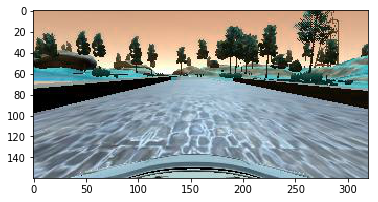

In [32]:
plt.imshow(image)

# Unblanced data  
checking the balance of the data. 

Text(0,0.5,'count')

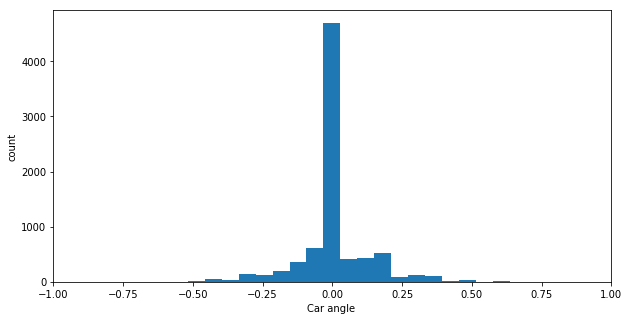

In [33]:
steering_angle=[]
for line in samples[1:len(samples)]:
    steering_angle.append(np.float(line[3]))
plt.figure(figsize=(10,5))
plt.hist(steering_angle,bins=32)
plt.xlim(-1.0,1.0)
plt.xlabel("Car angle ")
plt.ylabel("count")

From the above figures we can easily draw that steerig angles are straight most of the time. it is due to the nature of track. since I have used sample data fom udacity. this data is normal in nature.|

# overfitting 
There are millions of parameters in CNN and it requires millions of instances for fitting those parameters. Since our dats is small so overfitting is going to happen. to avoid overfitting we will augment the data. 

# Brightness augmentation
converting images to HLS and working with the L channel for lightning up and down the image  

In [34]:
def brightness(image):
    Img = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    Img = np.array(Img,dtype=np.float64)
    #for beightness
    random_brightness = 0.5+np.random.uniform()
    Img[:,:,1] = Img[:,:,1]*random_brightness
    Img[:,:,1][Img[:,:,1]>155] = 255
    Img= np.array(Img, dtype=np.uint8)
    new_Img = cv2.cvtColor(Img,cv2.COLOR_HLS2RGB)
    return new_Img

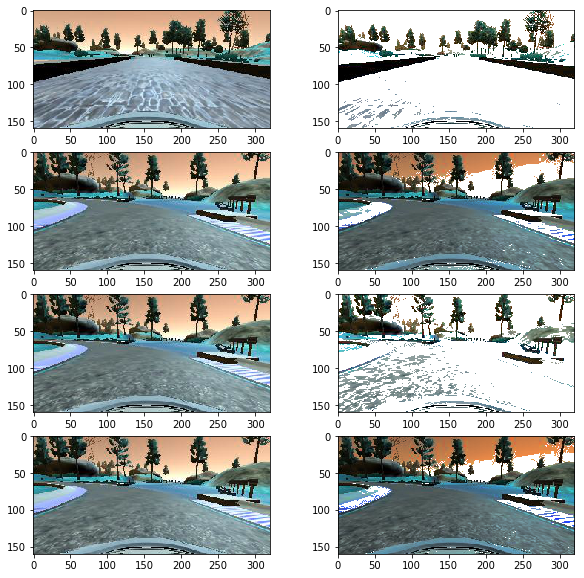

In [35]:
fig,ax=plt.subplots(4,2,figsize=(10,10))
ax = ax.ravel()
j=0
for i in range(1,5,1):
    address='data/'+(samples[i][0].split('\\'))[-1]
    image = cv2.imread(address,cv2.IMREAD_COLOR)
    ax[j].imshow(image)
    j+=1
    bright_image = brightness(image)
    ax[j].imshow(bright_image)
    j+=1
    

# Horizental and vertical shift

In [36]:
def translation(img, angle, x_quantity, y_quantity):
    # x_translation will be between (-quantity/2,qyantity/2)
    x_translation= x_quantity*np.random.uniform()-x_quantity/2
    translated_angle = angle+x_translation/x_quantity*2*.2
    y_translation = y_quantity*np.random.uniform()-y_quantity/2
    num_rows, num_cols = img.shape[:2]
    translation_matrix = np.float32([ [1,0,x_translation], [0,1,y_translation] ])
    img_translation = cv2.warpAffine(img, translation_matrix, (num_cols, num_rows))
    return img_translation, translated_angle

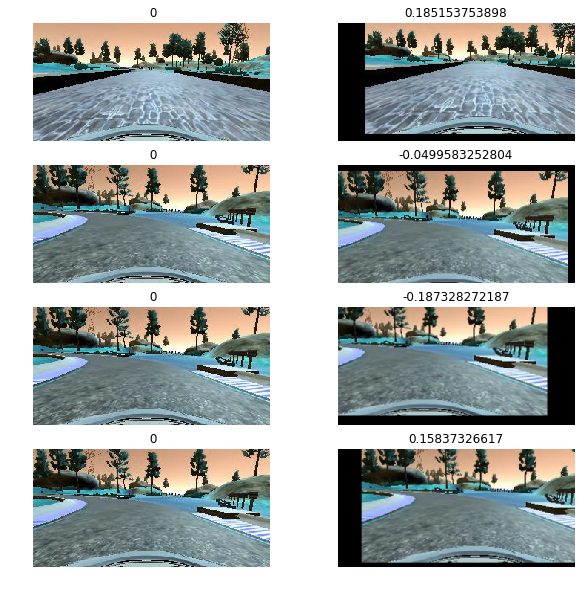

In [37]:
x_quantity =80
y_quantity=30
fig,ax=plt.subplots(4,2,figsize=(10,10))
ax = ax.ravel()
j=0
for i in range(1,5,1):
    address='data/'+(samples[i][0].split('\\'))[-1]
    image = cv2.imread(address,cv2.IMREAD_COLOR)
    ax[j].imshow(image)
    ax[j].axis('off')
    ax[j].set_title(str(samples[i][3]))
    j+=1
    translated_image, translated_angle = translation(image,np.float32(samples[i][3]),x_quantity,y_quantity)
    ax[j].imshow(translated_image)
    ax[j].axis('off')
    ax[j].set_title(str(translated_angle))
    j+=1

# Shadow augmentations

In [38]:
def shadow(img):
    bright_factor = 0.3
    height, width =  image.shape[:2]
    random_x=np.random.randint(0,width)
    ranndom_y=np.random.randint(0,height)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    random_width = np.random.randint(np.int(width/2),width)
    if(random_x+random_width>width):
        random_x=width-random_x
    random_height = np.random.randint(np.int(height/2), height)
    if(ranndom_y+random_height>height):
        ranndom_y = height-ranndom_y
    img[ranndom_y:ranndom_y+random_height, random_x:random_x+random_width,2]=img[ranndom_y:ranndom_y+random_height, random_x:random_x+random_width,2]*bright_factor
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

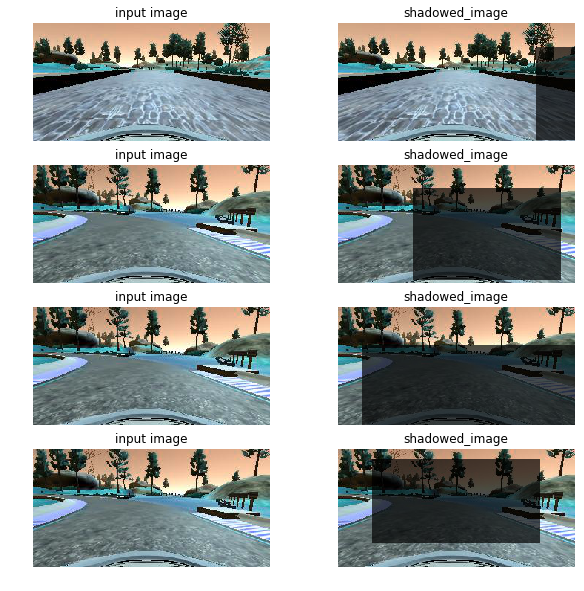

In [39]:
fig,ax=plt.subplots(4,2,figsize=(10,10))
ax = ax.ravel()
j=0
for i in range(1,5,1):
    address='data/'+(samples[i][0].split('\\'))[-1]
    image = cv2.imread(address,cv2.IMREAD_COLOR)
    ax[j].imshow(image)
    ax[j].axis('off')
    ax[j].set_title('input image')
    j+=1
    shadowed_image = shadow(image)
    ax[j].imshow(shadowed_image)
    ax[j].axis('off')
    ax[j].set_title('shadowed_image')
    j+=1

# flipping 


In [40]:
def flip(image,angle):
    return cv2.flip(image,1), -1*angle

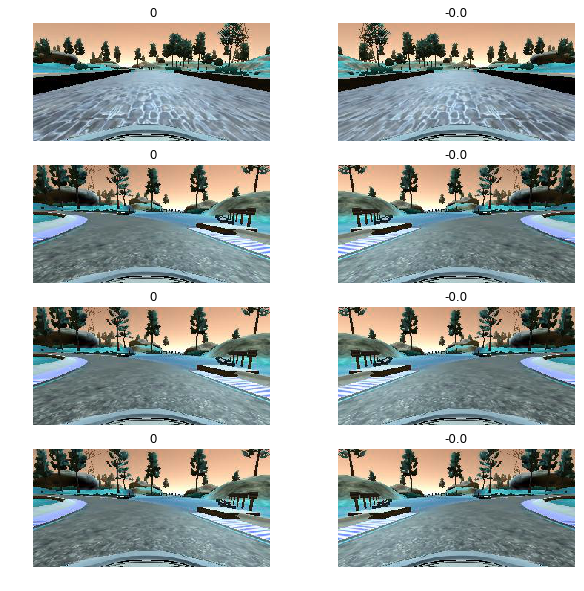

In [41]:
fig,ax=plt.subplots(4,2,figsize=(10,10))
ax = ax.ravel()
j=0
for i in range(1,5,1):
    address='data/'+(samples[i][0].split('\\'))[-1]
    image = cv2.imread(address,cv2.IMREAD_COLOR)
    ax[j].imshow(image)
    ax[j].axis('off')
    ax[j].set_title(str(samples[i][3]))
    j+=1
    flipped_image, flipped_angle = flip(image,np.float32(samples[i][3]))
    ax[j].imshow(flipped_image)
    ax[j].axis('off')
    ax[j].set_title(str(flipped_angle))
    j+=1

# Resize

In [42]:
def resize_(image):
    return cv2.resize(image,(64,64), interpolation = cv2.INTER_AREA)

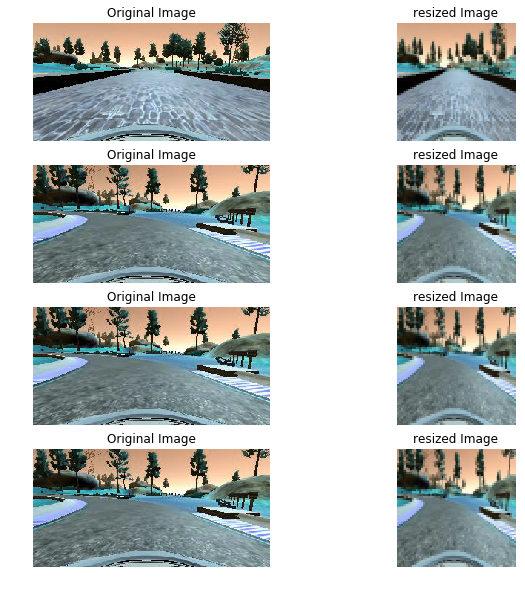

In [43]:
fig,ax=plt.subplots(4,2,figsize=(10,10))
ax = ax.ravel()
j=0
for i in range(1,5,1):
    address='data/'+(samples[i][0].split('\\'))[-1]
    image = cv2.imread(address,cv2.IMREAD_COLOR)
    ax[j].imshow(image)
    ax[j].set_title('Original Image')
    ax[j].axis('off')
    j+=1
    resized_image = resize_(image)
    ax[j].imshow(resized_image)
    ax[j].set_title('resized Image')
    ax[j].axis('off')
    j+=1

# Cropping
1/3 of the top of the image is cropped. Due to the Car hood in the picture last 25 pixel are also removed from the image

In [44]:
def crop_(image):
    shape = image.shape
    return image[50:shape[0]-25,0:shape[1]]

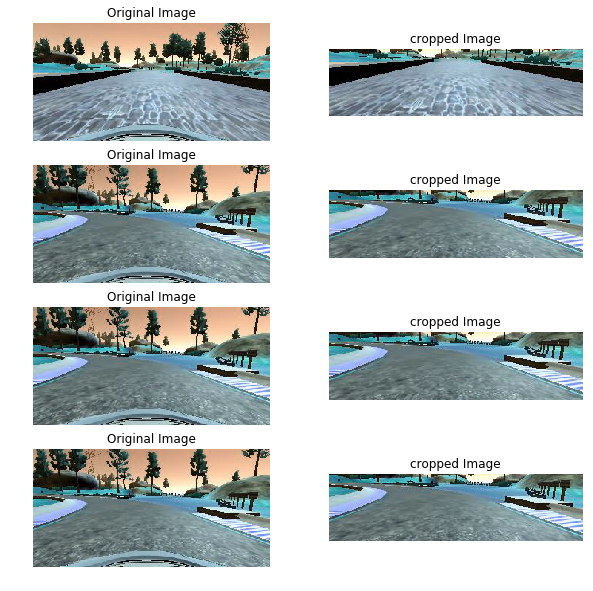

In [45]:
fig,ax=plt.subplots(4,2,figsize=(10,10))
ax = ax.ravel()
j=0
for i in range(1,5,1):
    address='data/'+(samples[i][0].split('\\'))[-1]
    image = cv2.imread(address,cv2.IMREAD_COLOR)
    ax[j].imshow(image)
    ax[j].set_title('Original Image')
    ax[j].axis('off')
    j+=1
    cropped_image = crop_(image)
    ax[j].imshow(cropped_image)
    ax[j].set_title('cropped Image')
    ax[j].axis('off')
    j+=1

# Normalize Image

In [46]:
def normalize_(image):
    image = image / 255 - 0.5
    return image

In [47]:
fig,ax=plt.subplots(4,2,figsize=(10,10))
ax = ax.ravel()
j=0
for i in range(1,5,1):
    address='data/'+(samples[i][0].split('\\'))[-1]
    image = cv2.imread(address,cv2.IMREAD_COLOR)
    ax[j].imshow(image)
    ax[j].set_title('Original Image')
    ax[j].axis('off')
    j+=1
    normalized_image = normalize_(image)
    ax[j].imshow(normalized_image)
    ax[j].set_title('normalized Image')
    ax[j].axis('off')
    j+=1

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000002367D597158> (for post_execute):


ValueError: Floating point image RGB values must be in the 0..1 range.

ValueError: Floating point image RGB values must be in the 0..1 range.

In [48]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [49]:
def preprocess_(new_image, new_angle):
    
    
    
    toss_translation = np.random.randint(2)
    if(toss_translation==0):
        new_image, new_angle = translation(new_image,new_angle,100,40)
    
    new_image = brightness(new_image)
    
    toss_shadow = np.random.randint(2)
    if(toss_shadow==0):
        new_image = shadow(new_image)
        
    new_image = crop_(new_image)
    new_image = resize_(new_image)
    toss_coin = np.random.randint(2)
    if(toss_coin==0):
        new_image, new_angle = flip(new_image,new_angle)
    return new_image, new_angle

In [50]:
samples[1]

['IMG/center_2016_12_01_13_30_48_404.jpg',
 ' IMG/left_2016_12_01_13_30_48_404.jpg',
 ' IMG/right_2016_12_01_13_30_48_404.jpg',
 ' 0',
 ' 0',
 ' 0',
 ' 21.87963']

https://medium.com/@fromtheast/implement-fit-generator-in-keras-61aa2786ce98

In [51]:
def generator(samples, batch_size=256):
    np.random.shuffle(samples)
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        #shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                
                
                
                
                camera_toss = np.random.randint(3)
                if(camera_toss == 0):
                    image = cv2.imread('data/'+batch_sample[0],cv2.IMREAD_COLOR)
                    steer=0
                if(camera_toss==1):
                    image = cv2.imread('data/'+batch_sample[1].strip(),cv2.IMREAD_COLOR)
                    steer=0.25
                if(camera_toss==2):
                    image = cv2.imread('data/'+batch_sample[2].strip(),cv2.IMREAD_COLOR)
                    steer = -0.25
                
                angle = np.float(batch_sample[3])+ steer               
                            
                
                processed_image,processed_angle=preprocess_(image, angle)                
                 
                images.append(processed_image)
               
                
                angles.append(processed_angle)
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [52]:
train_samples[1]

['IMG/center_2016_12_01_13_43_22_610.jpg',
 ' IMG/left_2016_12_01_13_43_22_610.jpg',
 ' IMG/right_2016_12_01_13_43_22_610.jpg',
 ' -0.2686331',
 ' 0.9855326',
 ' 0',
 ' 30.1829']

In [54]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

INPUT_SHAPE=64,64,3
model = Sequential()

model.add(Lambda(normalize_,input_shape=INPUT_SHAPE))
model.add(Conv2D(filters=24, kernel_size=5, activation='elu', strides=(2,2)))
model.add(Conv2D(filters=36, kernel_size=5, activation='elu', strides=(2,2)))
model.add(Conv2D(filters=48, kernel_size=5, activation='elu', strides=(2,2)))
model.add(Conv2D(filters=64, kernel_size=3,  activation='elu'))
#model.add(Conv2D(filters=64, kernel_size=3,  activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()

model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator,validation_data=validation_generator, 
                    validation_steps=len(validation_samples),steps_per_epoch=20000, epochs=3)
model.save('model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 24)        1824      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 13, 36)        21636     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 5, 5, 48)          43248     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 3, 3, 64)          27712     
_________________________________________________________________
dropout_8 (Dropout)          (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)               0         
__________